In [34]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [7]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', None)        
pd.set_option('display.expand_frame_repr', False)

In [8]:
df = pd.read_csv('train.csv')

In [9]:
df.shape

(1460, 81)

In [10]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Transformer Classes

In [27]:
## This class takes care of missing values, it drops columns if missing values are more than specific threshold, and 
## Takes Care of numerical and categorical column's missing values as provided strategy. can use median or mean for numericals
## and mode for categorical column values.

from sklearn.base import BaseEstimator, TransformerMixin

class MissingValueHandler(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.5, num_strategy='median', cat_strategy='mode'):
        self.threshold = threshold
        self.num_strategy = num_strategy
        self.cat_strategy = cat_strategy
        self.num_impute_values = {}
        self.cat_impute_values = {}
    
    def fit(self, X, y=None):
        missing_percent = X.isna().mean()
        self.cols_to_drop_ = missing_percent[missing_percent > self.threshold].index.tolist()
        
        for col in X.columns:
            if col in self.cols_to_drop_:
                continue
            if X[col].dtype == 'object':
                self.cat_impute_values[col] = X[col].mode()[0]
            else:
                if self.num_strategy == 'median':
                    self.num_impute_values[col] = X[col].median()
                elif self.num_strategy == 'mean':
                    self.num_impute_values[col] = X[col].mean()
        return self
    
    def transform(self, X):
        X = X.copy()
        X = X.drop(columns=self.cols_to_drop_, errors='ignore')
        
        for col, val in self.cat_impute_values.items():
            if col in X.columns:
                X[col] = X[col].fillna(val)
        
        for col, val in self.num_impute_values.items():
            if col in X.columns:
                X[col] = X[col].fillna(val)
                
        return X


In [16]:
## This class standardize or scale numerical features so that they will be on a similar scale 

class NumFeatureScaler(BaseEstimator, TransformerMixin):
    def __init__(self, num_cols):
        self.num_cols = num_cols
        self.scaler = StandardScaler()
    
    def fit(self, X, y=None):
        self.scaler.fit(X[self.num_cols])
        return self
    
    def transform(self, X):
        X = X.copy()
        X[self.num_cols] = self.scaler.transform(X[self.num_cols])
        return X

In [30]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

class CatFeatureEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cat_cols, strategy='onehot'):
        self.cat_cols = cat_cols
        self.strategy = strategy
        self.encoder = None

    def fit(self, X, y=None):
        self.existing_cat_cols_ = [col for col in self.cat_cols if col in X.columns]
        if self.strategy == 'onehot':
            self.encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
            self.encoder.fit(X[self.existing_cat_cols_])
        # If you implement other strategies, add them here.
        return self

    def transform(self, X):
        X = X.copy()
        cols_to_encode = [col for col in self.cat_cols if col in X.columns]
        if self.strategy == 'onehot' and cols_to_encode:
            encoded_array = self.encoder.transform(X[cols_to_encode])
            encoded_df = pd.DataFrame(
                encoded_array, 
                columns=self.encoder.get_feature_names_out(cols_to_encode),
                index=X.index
            )
            X = X.drop(columns=cols_to_encode)
            X = pd.concat([X, encoded_df], axis=1)
        return X


In [18]:
class LinearRegressionModel(BaseEstimator):
    def __init__(self, **kwargs):
        self.model = LinearRegression(**kwargs)
    
    def fit(self, X, y):
        self.model.fit(X, y)
        return self
    
    def predict(self, X):
        return self.model.predict(X)

# Train

In [ ]:
X = df.drop(columns=["SalePrice", "Id"])
Y = df["SalePrice"]

In [12]:
num_cols = [col for col in X.columns if X[col].dtype != 'object']
cat_cols = [col for col in X.columns if X[col].dtype == 'object']

In [31]:
pipeline = Pipeline([
    ('missing_handler', MissingValueHandler(threshold=0.4, num_strategy='median', cat_strategy='mode')),
    ('num_scaler', NumFeatureScaler(num_cols=num_cols)),
    ('cat_encoder', CatFeatureEncoder(cat_cols=cat_cols, strategy='onehot')),
    ('regressor', LinearRegressionModel())
])

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []

d:\FreeUni\Semester 6\ML\House-Prices-Regression\myenv\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Fold RMSE: 29680.09124680199


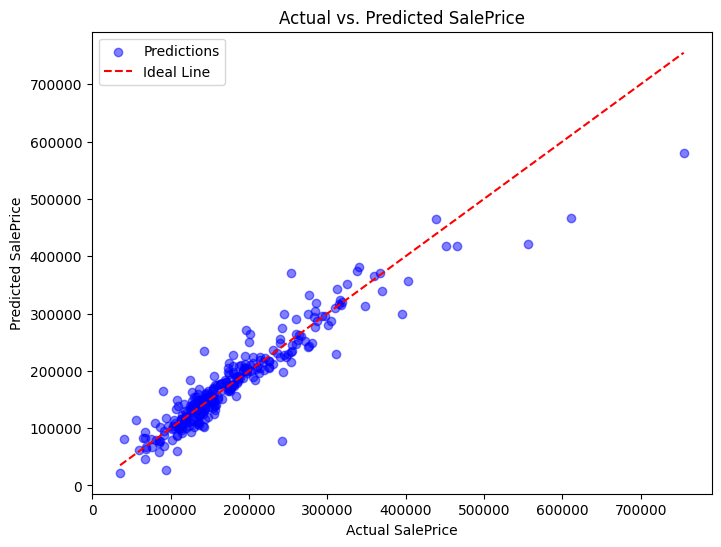

d:\FreeUni\Semester 6\ML\House-Prices-Regression\myenv\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Fold RMSE: 26878.429739009473


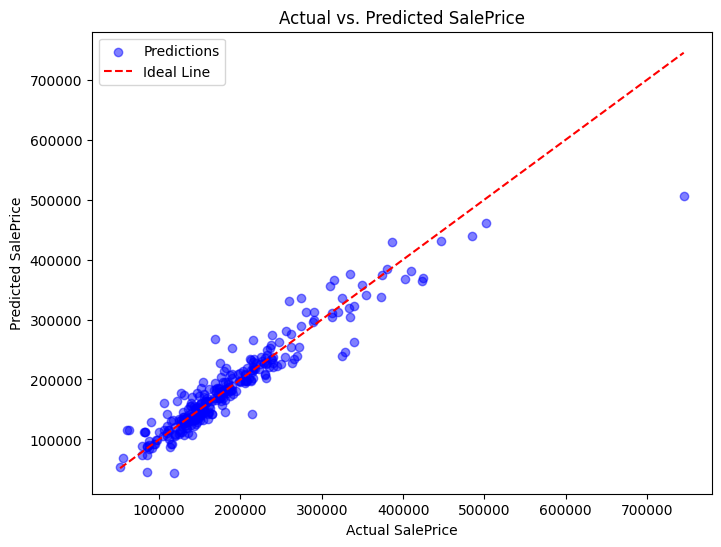

d:\FreeUni\Semester 6\ML\House-Prices-Regression\myenv\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Fold RMSE: 54927.75293062793


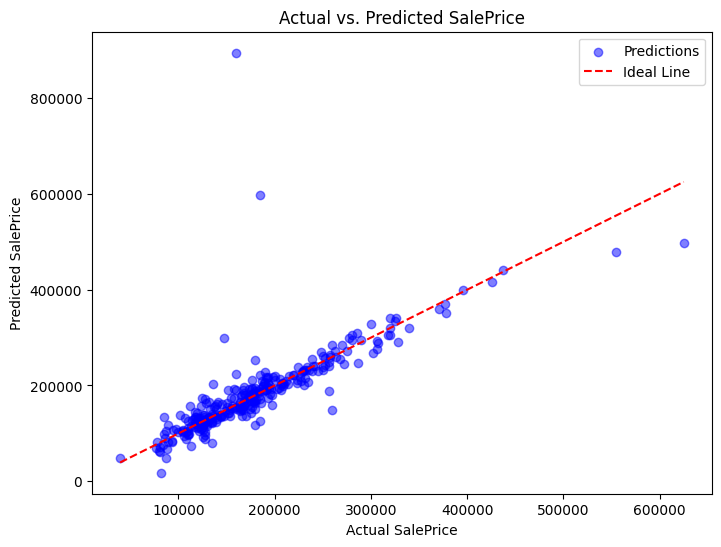

d:\FreeUni\Semester 6\ML\House-Prices-Regression\myenv\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Fold RMSE: 34433.69822414762


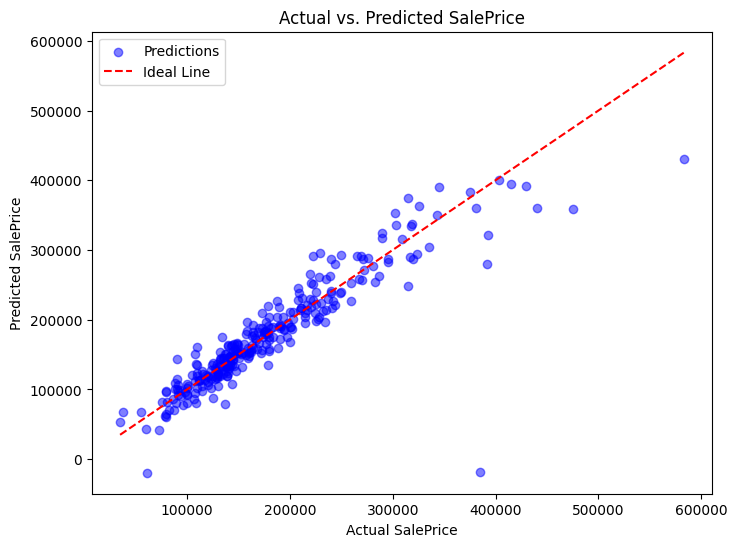

d:\FreeUni\Semester 6\ML\House-Prices-Regression\myenv\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Fold RMSE: 23525.94146529658


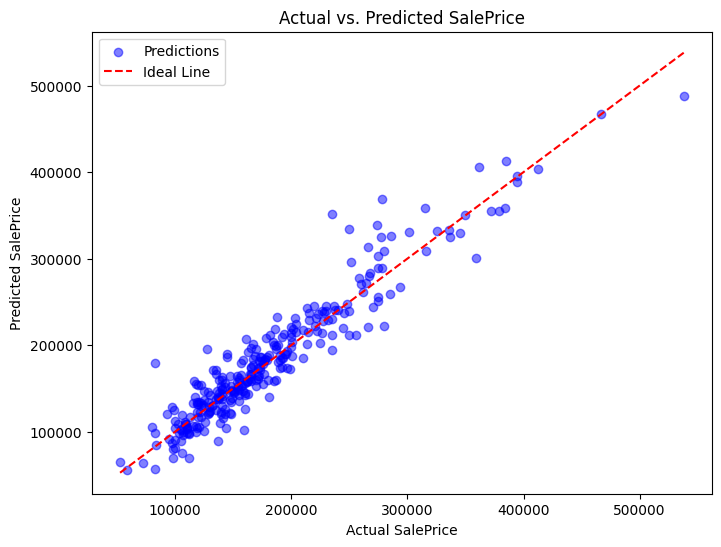

Average CV RMSE: 33889.18272117672


In [ ]:
for train_index, val_index in kf.split(X):
    X_train_cv, X_val_cv = X.iloc[train_index], X.iloc[val_index]
    y_train_cv, y_val_cv = Y.iloc[train_index], Y.iloc[val_index]
    
    pipeline.fit(X_train_cv, y_train_cv)
    
    y_pred = pipeline.predict(X_val_cv)
    
    rmse = np.sqrt(mean_squared_error(y_val_cv, y_pred))
    scores.append(rmse)
    print(f"Fold RMSE: {rmse}")

    plt.figure(figsize=(8, 6))
    plt.scatter(y_val_cv, y_pred, alpha=0.5, color='blue', label='Predictions')
    plt.plot([y_val_cv.min(), y_val_cv.max()], [y_val_cv.min(), y_val_cv.max()], 'r--', label='Ideal Line')
    plt.xlabel("Actual SalePrice")
    plt.ylabel("Predicted SalePrice")
    plt.title("Actual vs. Predicted SalePrice")
    plt.legend()
    plt.show()


print(f"Average CV RMSE: {np.mean(scores)}")

In [39]:
import dagshub
dagshub.init(repo_owner='losaberidzebadri', repo_name='House-Prices-Regression', mlflow=True)

import mlflow
with mlflow.start_run():
    mlflow.log_params({
        "missing_threshold": 0.4,
        "num_strategy": "median",
        "cat_encoding": "onehot"
    })
    mlflow.sklearn.log_model(pipeline, "model")
    mlflow.log_metric('Average CV RMSE', 33889.18272117672)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=e73fd809-61bd-4be5-8130-17ca00737657&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=1c82d13c4b761091e43dca1082af813f7e68caf701f977d433e83e648c23dc75




Accessing as losaberidzebadri

Initialized MLflow to track repo "losaberidzebadri/House-Prices-Regression"

Repository losaberidzebadri/House-Prices-Regression initialized!

2025/04/05 00:48:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run gentle-hare-242 at: https://dagshub.com/losaberidzebadri/House-Prices-Regression.mlflow/#/experiments/0/runs/80aa0003275d4fc38a25081f9012f47a
🧪 View experiment at: https://dagshub.com/losaberidzebadri/House-Prices-Regression.mlflow/#/experiments/0
